# 1. Data Load

In [1]:
import pandas as pd
import numpy as np
import os

# NOTE : data load
path = os.getcwd()
train = pd.read_csv(f'{path}/open/train.csv')
test = pd.read_csv(f'{path}/open/test.csv')

# 2. Preprocessing  
<br>
<br>

##### 1) feature engineering
##### 2) drop columns
##### 3) bining(변수 구간화)
##### 4) encoding
##### 5) scaling

In [2]:
from module import pre_1_datetime, pre_2_weekday, pre_3_ARI_PORT
from module import pre_4_ratio_under_water, pre_5_ratio_under_water_DEADWEIGHT
from module import pre_6_dist_binding, pre_7_drop, pre_8_encoding


# feature engineering / drop columns / bining
def preprocessing_1(data):
    
    data = pre_1_datetime(data)
    data = pre_2_weekday(data)
    data = pre_3_ARI_PORT(data)
    data = pre_4_ratio_under_water(data)
    data = pre_5_ratio_under_water_DEADWEIGHT(data)
    data = pre_6_dist_binding(data)
    data = pre_7_drop(data)
    
    return data


# encoding
def preprocessing_2(train, test):

    train, test = pre_8_encoding(train, test)

    return train, test


train = preprocessing_1(train)
test = preprocessing_1(test)

train, test = preprocessing_2(train, test)

In [3]:
from module import model_1_split_DIST, modeling_2_creterion_KF, modeling_3_make_creterion
from module import pre_9_drop, pre_10_scaling



# NOTE : Modeling 1 / 데이터셋 분할
# DIST가 0인 samples, 0이 아닌 samples로 분할
# 분할이유 
    #: EDA결과 DIST가 0인 경우 대부분 target(CI_HOUR)가 0이였음.
    #  따라서 DIST가 0이 아닌 경우는 DIST가 0인 상황을 제외하고 학습하는게 좋다고 판단.
train_0, train_1, test_0, test_1 = model_1_split_DIST(train, test)



# NOTE : Modeling 2 / K-Fold 데이터셋 분할 기준 생성(1)
# train_0, test_0 : target(CI_HOUR)이 24시간 미만이면 0, 이상이면 1
# train_1, test_1 : target(CI_HOUR)이 100시간 미만이면 0, 이상이면 1
train_0 = modeling_2_creterion_KF(train_0, 24)
train_1 = modeling_2_creterion_KF(train_1, 100)



# DIST가 0인 데이터셋에 한해서 'weekday'column 제거
train_0 = pre_9_drop(train_0)
test_0 = pre_9_drop(test_0)



# stratified KF 검증 시 데이터셋 분할 기준 생성
SPLIT_CRETERION_0, SPLIT_CRETERION_1 = modeling_3_make_creterion(train_0, train_1)


# scaling
train_x_0, train_y_0, test_0 = pre_10_scaling(train_0, test_0)
train_x_1, train_y_1, test_1 = pre_10_scaling(train_1, test_1)

print('\n✅ 전처리 완료')

DIST = 0(train) : (157293, 28)
DIST != 0(train) : (234646, 28)

✅ 전처리 완료


# 3. Modeling  
<br>
<br>

##### 1) feature importance 계산
##### 2) drop columns
##### 3) best model 찾기
##### 4) stratified K-Fold 검증 및 추론

In [4]:
# from module import modeling_4_feature_importance, modeling_5_drop_columns_based_fi
# from module import modeling_6_grid_search, modeling_7_train_evaluation
# from xgboost import XGBRegressor
# import warnings

# warnings.filterwarnings(action='ignore')

In [5]:
# def modeling(train_x, train_y, test, model, model_name, threshold, params_grid, SPLIT_CRETERION):


#     # NOTE : Modeling 4 / 변수 중요도 추출 및 시각화
#     trained_model, feature_importances = modeling_4_feature_importance(model, model_name, train_x, train_y)


#     # NOTE : Modeling 5 / 변수 중요도 기반 전처리
#     # threshold보다 중요도가 낮은 column은 제거
#     # 실험에 의해 threshold = 0.004가 가장 좋은 성능을 보여주는 것 확인
#     train_x, test = modeling_5_drop_columns_based_fi(train_x, test, feature_importances, threshold)



#     # NOTE : Modeling 6 / 최적 하이퍼파라미터
#     # Grid Search를 사용해 모델의 최적 하이퍼파라미터 조합발견
#     best_model, best_params = modeling_6_grid_search(train_x, train_y, model, params_grid)
#     print('\n\n✅ Best Hyperparameters :\n', best_params)


#     # NOTE : Modeling 7 / Stratified K-Fold
#     # best model에 Stratified K-Fold적용 후 학습, 검증, 추론 수행
#     final_predictions = modeling_7_train_evaluation(train_x, train_y, test, best_model, SPLIT_CRETERION)

#     return final_predictions

In [6]:
from module import modeling_4_feature_importance, modeling_5_grid_search, modeling_6_train_evaluation
#from module import modeling_6_grid_search, modeling_7_train_evaluation
from xgboost import XGBRegressor
import warnings

warnings.filterwarnings(action='ignore')

In [7]:
def modeling(train_x, train_y, test, model, model_name, threshold, params_grid, SPLIT_CRETERION):


    # NOTE : Modeling 4 / 변수 중요도 추출 및 시각화, 시각화
    # threshold보다 중요도가 낮은 column은 제거
    # 실험에 의해 threshold = 0.004가 가장 좋은 성능을 보여주는 것 확인
    train_x, test, trained_model, feature_importances = modeling_4_feature_importance(train_x, train_y, test, model, model_name, threshold)


    # NOTE : Modeling 6 / 최적 하이퍼파라미터
    # Grid Search를 사용해 모델의 최적 하이퍼파라미터 조합발견
    best_model, best_params = modeling_5_grid_search(train_x, train_y, model, params_grid)
    print('\n\n✅ Best Hyperparameters :\n', best_params)


    # NOTE : Modeling 7 / Stratified K-Fold
    # best model에 Stratified K-Fold적용 후 학습, 검증, 추론 수행
    final_predictions = modeling_6_train_evaluation(train_x, train_y, test, best_model, SPLIT_CRETERION)

    return final_predictions

### 1) DIST가 0인 경우

In [8]:
params_grid = {
    'eta': [0.02, 0.03, 0.04],  # 학습률 (learning rate)
    'n_estimators': range(400, 550, 50),  # 예측기(트리)의 개수
    'min_child_weight': [1, 1.25, 1.5],  # 리프 노드의 최소 가중치 합    
    'max_depth': range(10, 16, 2),  # 트리의 최대 깊이    
    'lambda': [2.5, 3, 3.5],  # L2 규제 (람다)
    'alpha': [ 3 ],  # L1 규제 (알파)

    'gamma': [0.2],  # 트리 노드를 분할하는 데 필요한 최소 손실 감소
    'colsample_bytree': [0.8],  # 트리를 구성할 때 열 샘플링 비율
}

Model Tune for XGBRegressor.


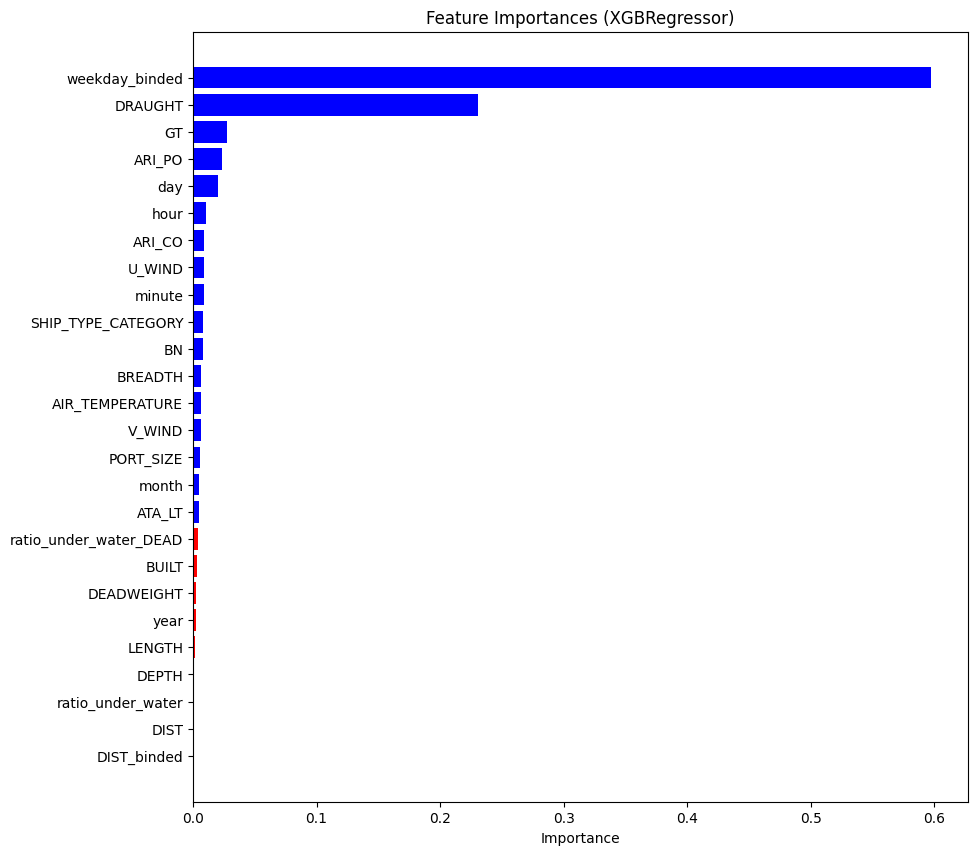

💡 제거된 column들 
: ['DIST', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'LENGTH', 'year', 'ratio_under_water', 'ratio_under_water_DEAD', 'DIST_binded']


✅ Best Hyperparameters :
 {'alpha': 3, 'colsample_bytree': 0.8, 'eta': 0.04, 'gamma': 0.2, 'lambda': 2.5, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 400}


Prediction Score
Validation : MAE for each fold: [0.011797943961677774, 0.024097228371963663, 0.002388787113794518, 0.021294653029057357, 0.025968146967173335]
Validation : MAE: 0.01710935188873333


In [9]:
model_0 = XGBRegressor()
model_name_0 = 'XGBRegressor'



final_predictions_0 = modeling(train_x_0, train_y_0, test_0, model_0, model_name_0, 0.004, params_grid, SPLIT_CRETERION_0)

### 2) DIST가 0보다 큰 경우

Model Tune for XGBRegressor.


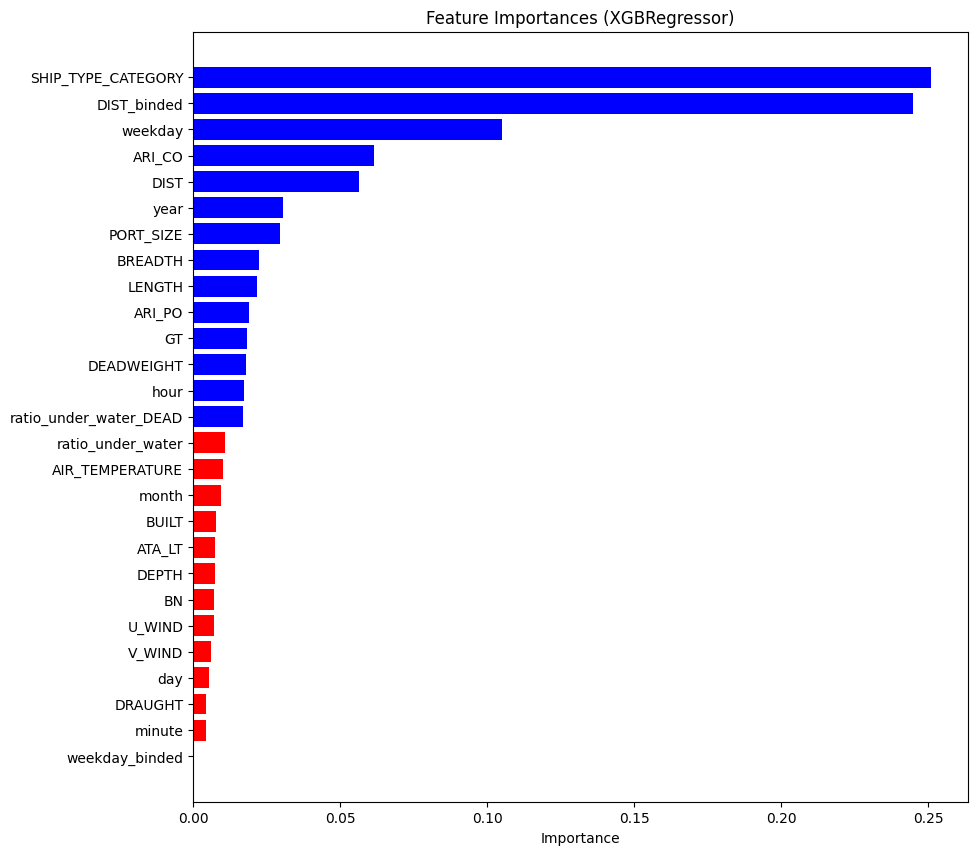

💡 제거된 column들 
: ['BUILT', 'DEPTH', 'DRAUGHT', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'ATA_LT', 'month', 'day', 'minute', 'weekday_binded', 'ratio_under_water']


✅ Best Hyperparameters :
 {'alpha': 3, 'colsample_bytree': 0.8, 'eta': 0.02, 'gamma': 0.2, 'lambda': 3, 'max_depth': 14, 'min_child_weight': 1.25, 'n_estimators': 450}


Prediction Score
Validation : MAE for each fold: [73.27557026392293, 73.70083976964337, 74.01356542101907, 73.82304362388375, 72.77460029650194]
Validation : MAE: 73.51752387499421


In [10]:
model_1 = XGBRegressor()
model_name_1 = 'XGBRegressor'



final_predictions_1 = modeling(train_x_1, train_y_1, test_1, model_1, model_name_1, 0.012, params_grid, SPLIT_CRETERION_1)

# 4. Inference

In [11]:
test = pd.read_csv(f'{path}/open/test.csv')

test_0 = test[test['DIST'] == 0]
test_1 = test[test['DIST'] != 0]

test_0['CI_HOUR'] = final_predictions_0
test_1['CI_HOUR'] = final_predictions_1


# SAMPLE_ID 순으로 정렬 후 submit을 위한 column만 남기기
submit = pd.concat([test_0, test_1]).sort_values('SAMPLE_ID')[['SAMPLE_ID', 'CI_HOUR']]

# save
submit.to_csv(f'{path}/open/submit.csv', index=False)